In [0]:
%tensorflow_version 2.x
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.grid'] = False

In [0]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

In [0]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image /= 255
  image = tf.image.resize([image], (224, 224))
  return image

def get_imagenet_label(probs):
  return tf.keras.applications.mobilenet_v2.decode_predictions(probs, top=1)[0][0]

In [0]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                                     'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

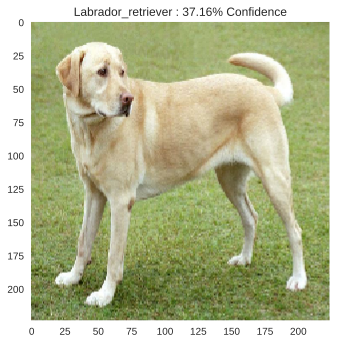

In [39]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [0]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1]) # shape (10000,)
label = tf.reshape(label, (1, image_probs.shape[-1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


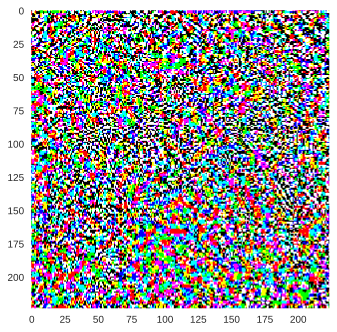

In [42]:
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])
plt.show()

In [0]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(
      description, label, confidence*100))
  plt.show()

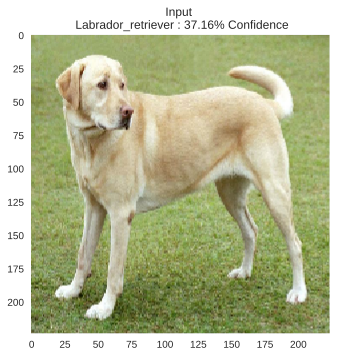

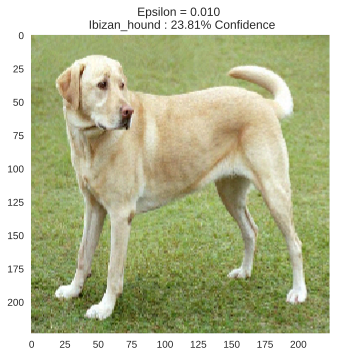

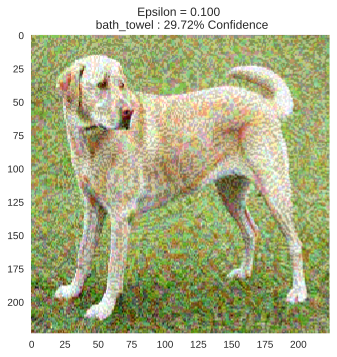

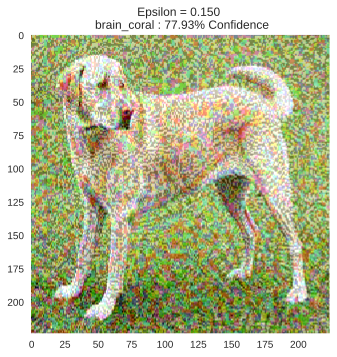

In [47]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for desc, eps in zip(descriptions, epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, desc)